# $$ Sarsa (\lambda)$$

## Imports

In [1]:
# imports from libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os

# imports from project
from utils.plotting import plot_line_graphs_overlayed
from utils.file_management import create_folder_structure
from utils.file_management import save_nparray_to_folder

## Setting Saving Directory

In [2]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"results","SARSA_LAMBDA_LFA")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA'

## Constants

In [3]:
# Initialize the "maze" environment
env = gym.make("maze-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 500
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
RENDER_MAZE = False
ENABLE_RECORDING = False

'''
Sarsa Lambda Related Constants
'''

DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.01
EPSILON = 1
EPSILON_DECAY = 0.999
LAMBDA_VAL_TRACE_DECAY_LIST = [0,0.2,0.4,0.6,0.8,1.0]


'''
CREATING RESULTS SAVING FOLDERS
'''
SAVING_RESULTS_IMAGE_FODLER = os.path.join(SAVING_RESULTS_FODLER,"images")
SAVING_RESULTS_VIDEO_FODLER = os.path.join(SAVING_RESULTS_FODLER,"videos")
SAVING_RESULTS_ARRAY_FODLER = os.path.join(SAVING_RESULTS_FODLER,"arrays")
create_folder_structure(SAVING_RESULTS_IMAGE_FODLER)
create_folder_structure(SAVING_RESULTS_VIDEO_FODLER)
create_folder_structure(SAVING_RESULTS_ARRAY_FODLER)

'''
ENABLE RECORDING
'''
if ENABLE_RECORDING:
    env = gym.wrappers.Monitor(env,SAVING_RESULTS_VIDEO_FODLER, force=True)
    
    

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Simulation

In [4]:
def simulate(discount_factor:float=0.99,
            learning_rate:float=0.01,
            epsilon:float= 1,
            epsilon_decay:float= 0.999,
            trace_decay:int= 0):


    """Simulate Sarsa Algorythim .

    Args:
        discount_factor (float): gamma.
        epsilon (float): gamma.
        epsilon_decay (float): gamma.
        trace_decay (float): gamma.


    Returns:
        np.array(reward_episode_list): Numpy array with the episodes rewards
        np.array(explore_rate_episode_list): Numpy array with the episodes explore rates
        np.array(learning_rate_episode_list): Numpy array with the episodes learning rates
        np.array(num_streaks_episode_list): Numpy array with the episodes number of mazze completions
        np.array(length_episode_list): Numpy array with the episodes lengths
    """
    
    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []


    # Instantiating the learning related parameters
    #learning_rate = get_learning_rate(0) # alpha
    explore_rate = get_explore_rate(0)
     
    # Render tha maze
    env.render()
    
    #q_table # inicializar ela aqui.
    q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)
    

    #Initializain num streaks
    num_streaks= 0

    for episode in range(NUM_EPISODES):

 
        # Reset the environment
        obv = env.reset()
        
        # initialize Reward
        total_reward = 0
        
        # initialize episolon decay
        epsilon *= epsilon_decay

        # E(S,A) = 0
        E = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)
        
        # Initialize state
        state = state_to_bucket(obv)
        
        # initialize action    # VERIFICAR SE SEGUE A POLITICA   
        action = epsilon_greedy_police(state, explore_rate, q_table)
        
        for t in range(MAX_T):

            # Select an action
            next_action = epsilon_greedy_police(state, explore_rate, q_table)
            
            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            next_state = state_to_bucket(obv)
            total_reward += reward
            
            
            # TD = r + gamma * Q(S', A') - Q(S,A)
            # TD = sigma
            TD = reward + discount_factor * np.dot( X[:, MAZE_SIZE[0]*next_state[0] + next_state[1], next_action], weights) -  np.dot(X[: MAZE_SIZE[0]*state[0]+state[1], action], weights) 
            
            # E(S,A) = E(S,A) + 1
            E[state + (action,)] = TD *E[state + (action,)] +  X[MAZE_SIZE[0]*state[0]+state[1] , MAZE_SIZE[0]*state[0]+state[1], action]
            
            #For all s E S, a E A(s)
            for i in range(q_table.shape[-1]):
                # Q(S,A) = Q(S,A) + alpha * lamb * E
                q_table[:,:,i] += learning_rate * TD * E[:,:,i]    
                # E(s, a) =  gama * trace_decay * E * delta * E(s,a)
                E[:,:,i]  = discount_factor * trace_decay * E[:,:,i] 


            weights += learning_rate * TD * E[:,MAZE_SIZE[0]*state[0]+state[1], action]
            
            #S - S'
            state = next_state
            
            # A - A'
            action = next_action
            

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print(f"Episode {episode} finished after {t} time steps with total reward = {total_reward} (streak {num_streaks}).")

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print(f"Episode {episode} timed out at {t} with total reward = {total_reward}.")

        

        # Appending Episode values to the list
        reward_episode_list.append(total_reward)
        explore_rate_episode_list.append(explore_rate)
        num_streaks_episode_list.append(num_streaks)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)

    

    return (np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))

## Epsilon Greed Exploration

In [5]:
def epsilon_greedy_police(state, explore_rate, q_table):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

## Updating EXPLORE_RATE and LEARNING_RATE

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## Function that returns the actual state

In [7]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

4 time steps with total reward = 0.8959999999999999 (streak 0).
Episode 349 finished after 127 time steps with total reward = 0.8729999999999999 (streak 0).
Episode 350 finished after 94 time steps with total reward = 0.9059999999999999 (streak 0).
Episode 351 finished after 122 time steps with total reward = 0.8779999999999999 (streak 1).
Episode 352 finished after 100 time steps with total reward = 0.8999999999999999 (streak 0).
Episode 353 finished after 131 time steps with total reward = 0.8689999999999999 (streak 1).
Episode 354 finished after 100 time steps with total reward = 0.8999999999999999 (streak 0).
Episode 355 finished after 108 time steps with total reward = 0.8919999999999999 (streak 1).
Episode 356 finished after 80 time steps with total reward = 0.9199999999999999 (streak 0).
Episode 357 finished after 125 time steps with total reward = 0.8749999999999999 (streak 1).
Episode 358 finished after 103 time steps with total reward = 0.8969999999999999 (streak 0).
Episode 

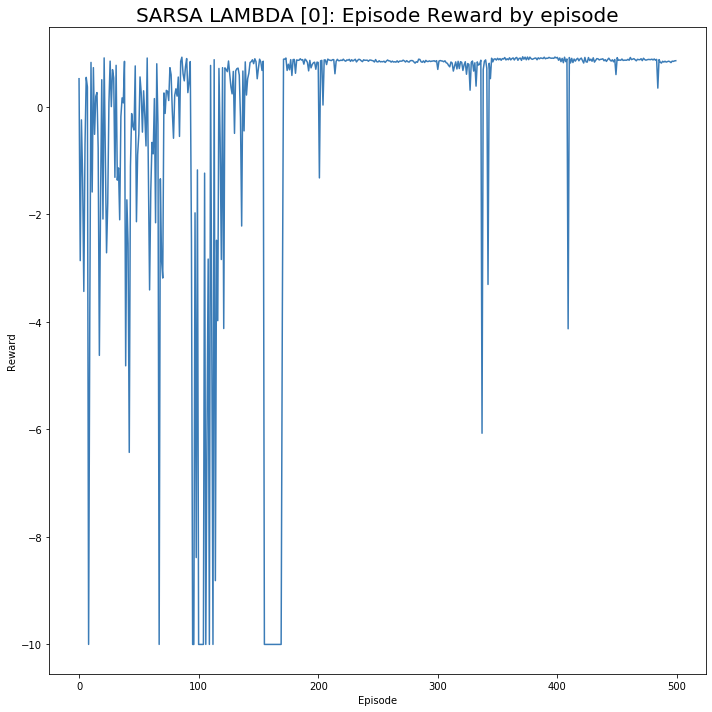

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

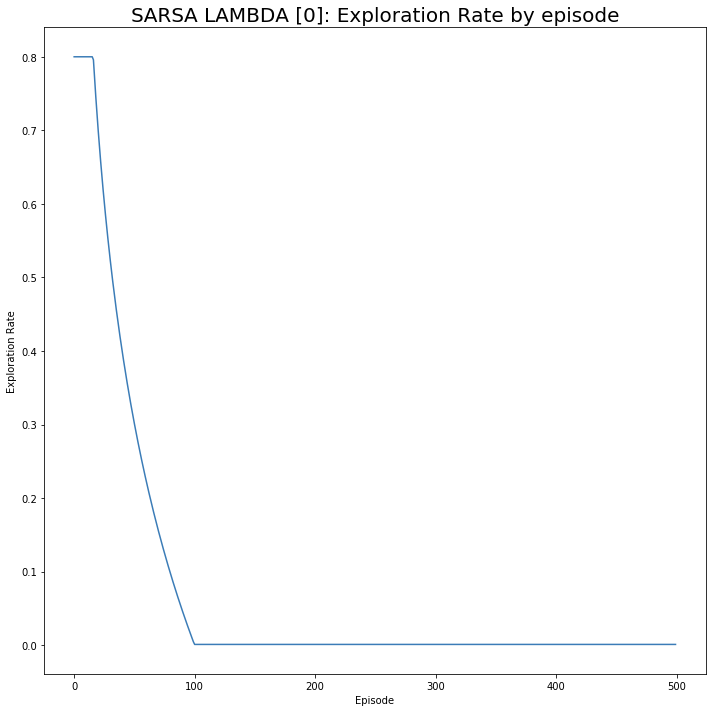

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

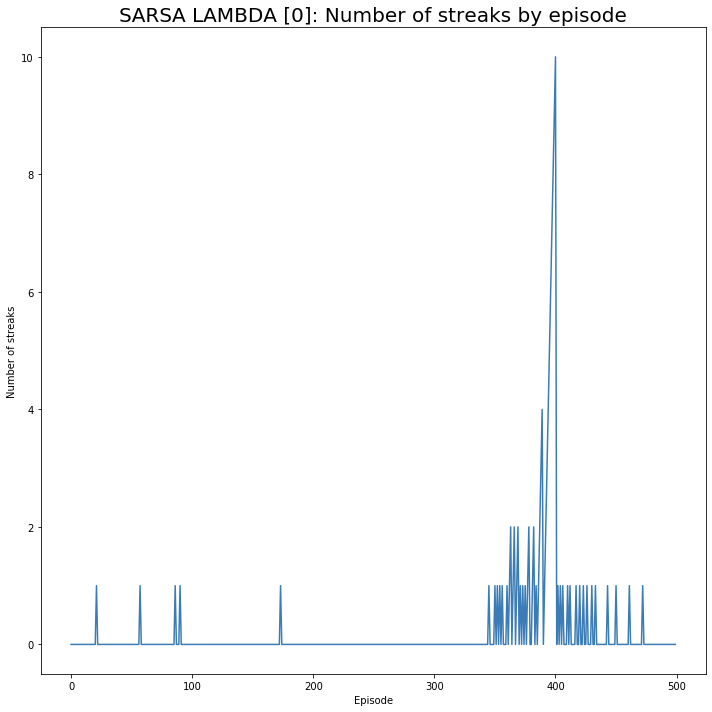

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

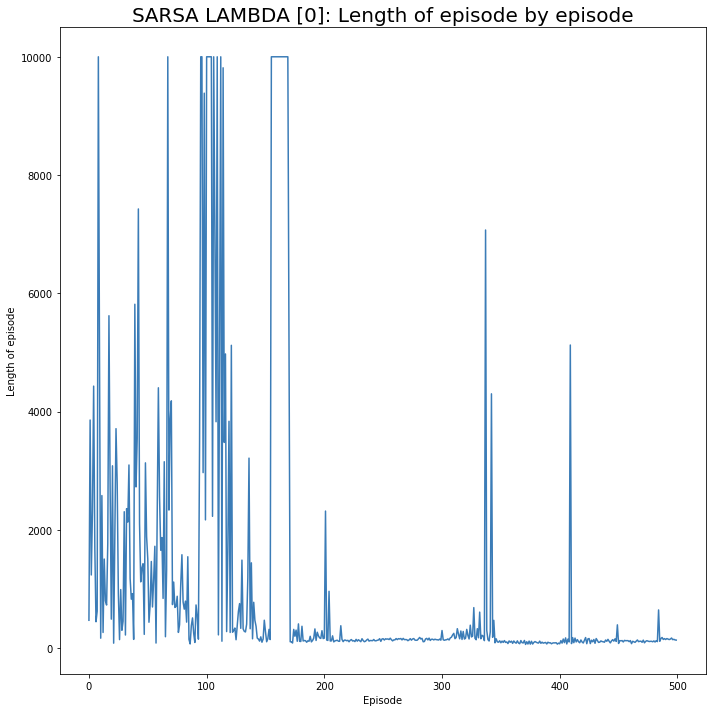

0.8859999999999999 (streak 0).
Episode 349 finished after 254 time steps with total reward = 0.7459999999999998 (streak 0).
Episode 350 finished after 119 time steps with total reward = 0.8809999999999999 (streak 0).
Episode 351 finished after 205 time steps with total reward = 0.7949999999999998 (streak 0).
Episode 352 finished after 150 time steps with total reward = 0.8499999999999999 (streak 0).
Episode 353 finished after 236 time steps with total reward = 0.7639999999999998 (streak 0).
Episode 354 finished after 941 time steps with total reward = 0.058999999999999275 (streak 0).
Episode 355 finished after 145 time steps with total reward = 0.8549999999999999 (streak 0).
Episode 356 finished after 183 time steps with total reward = 0.8169999999999998 (streak 0).
Episode 357 finished after 137 time steps with total reward = 0.8629999999999999 (streak 0).
Episode 358 finished after 172 time steps with total reward = 0.8279999999999998 (streak 0).
Episode 359 finished after 166 time s

<Figure size 432x288 with 0 Axes>

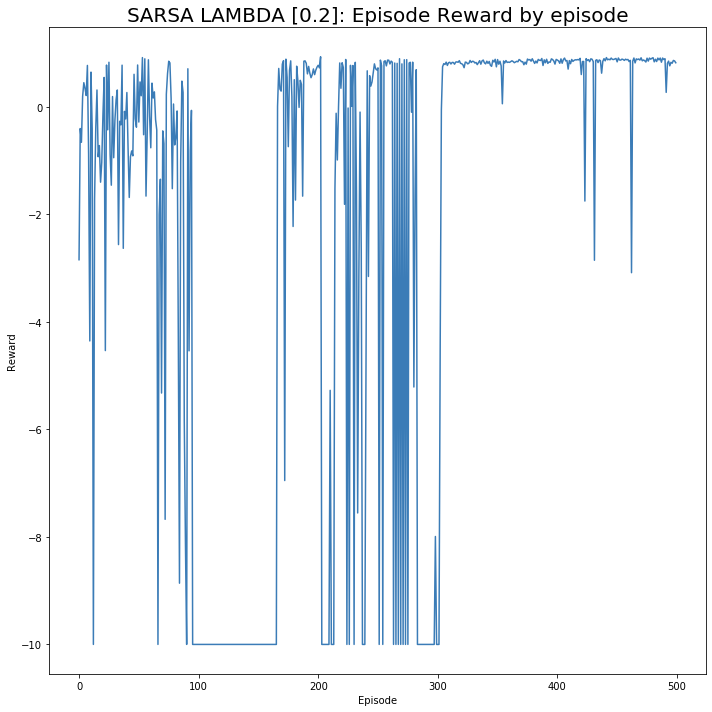

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.2\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

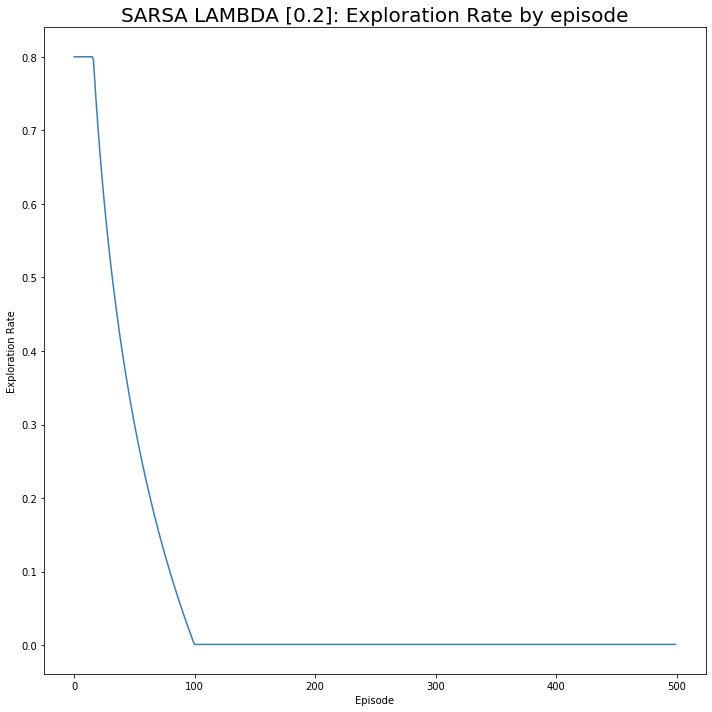

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.2\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

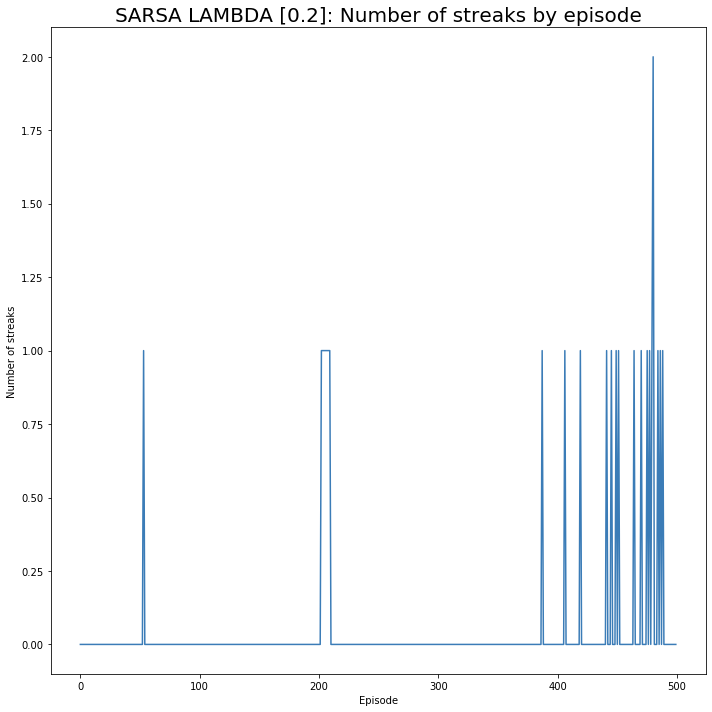

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.2\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

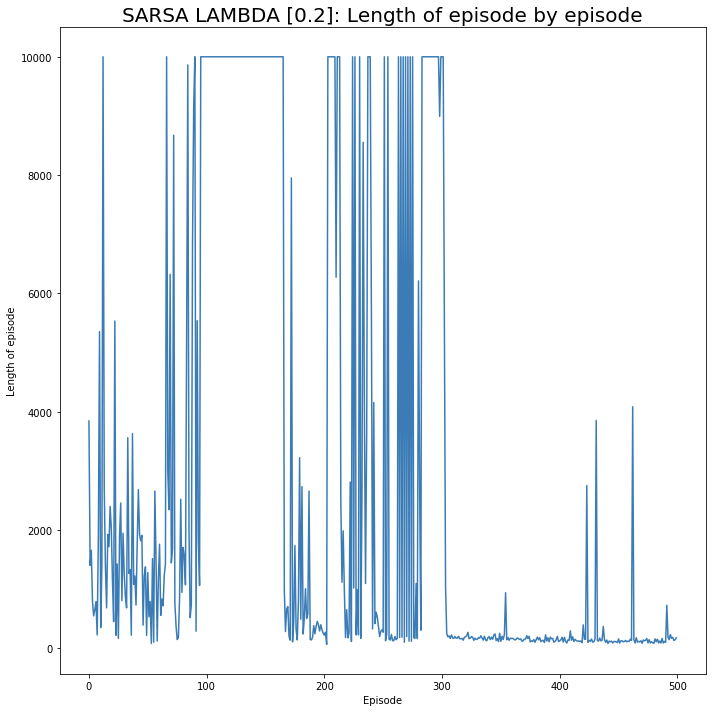

l reward = 0.5589999999999997 (streak 0).
Episode 349 finished after 543 time steps with total reward = 0.45699999999999963 (streak 0).
Episode 350 finished after 2472 time steps with total reward = -1.4719999999998388 (streak 0).
Episode 351 finished after 326 time steps with total reward = 0.6739999999999997 (streak 0).
Episode 352 finished after 357 time steps with total reward = 0.6429999999999998 (streak 0).
Episode 353 finished after 496 time steps with total reward = 0.5039999999999996 (streak 0).
Episode 354 finished after 2088 time steps with total reward = -1.087999999999881 (streak 0).
Episode 355 finished after 368 time steps with total reward = 0.6319999999999997 (streak 0).
Episode 356 finished after 2641 time steps with total reward = -1.6409999999998202 (streak 0).
Episode 357 finished after 345 time steps with total reward = 0.6549999999999998 (streak 0).
Episode 358 finished after 2251 time steps with total reward = -1.250999999999863 (streak 0).
Episode 359 finished 

<Figure size 432x288 with 0 Axes>

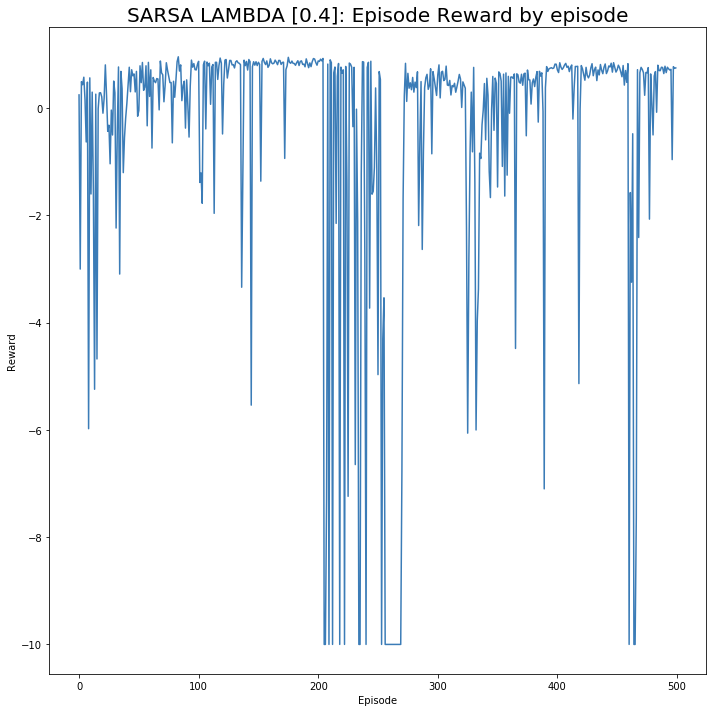

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

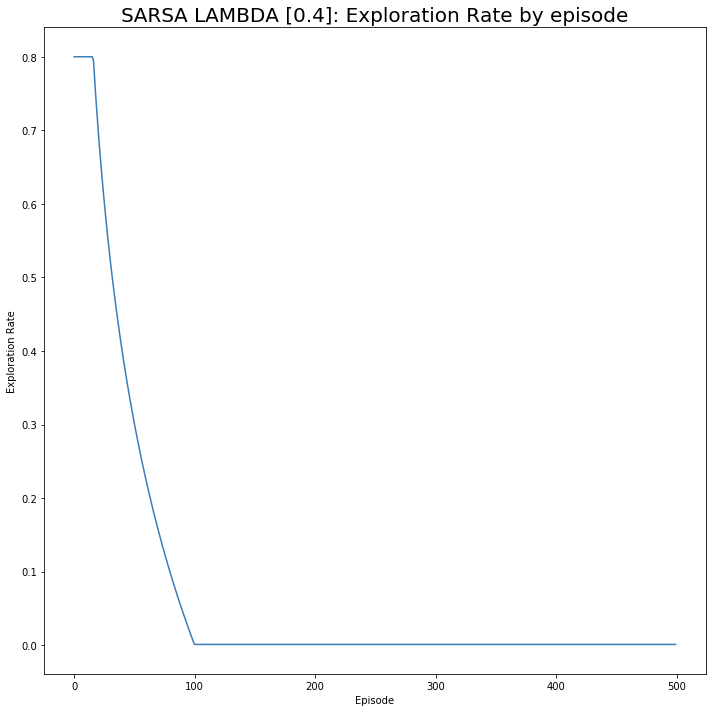

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

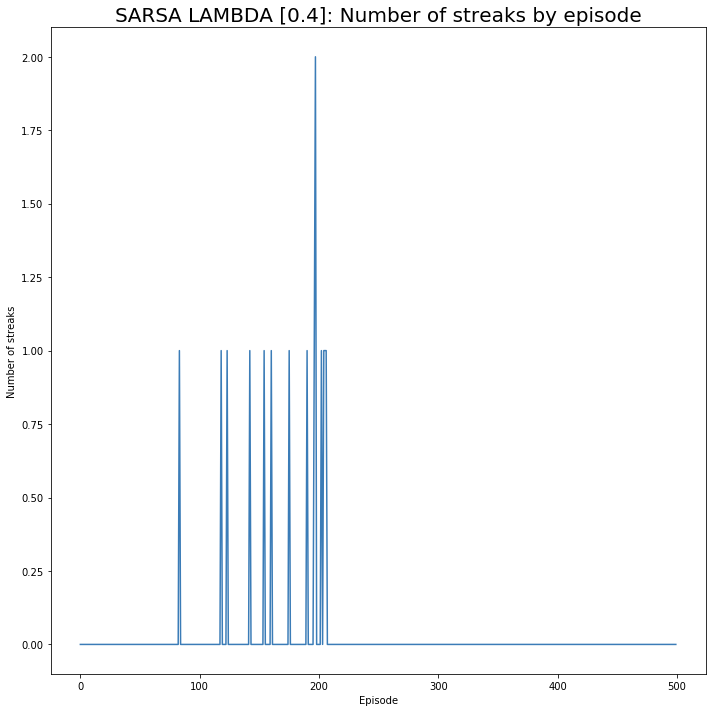

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

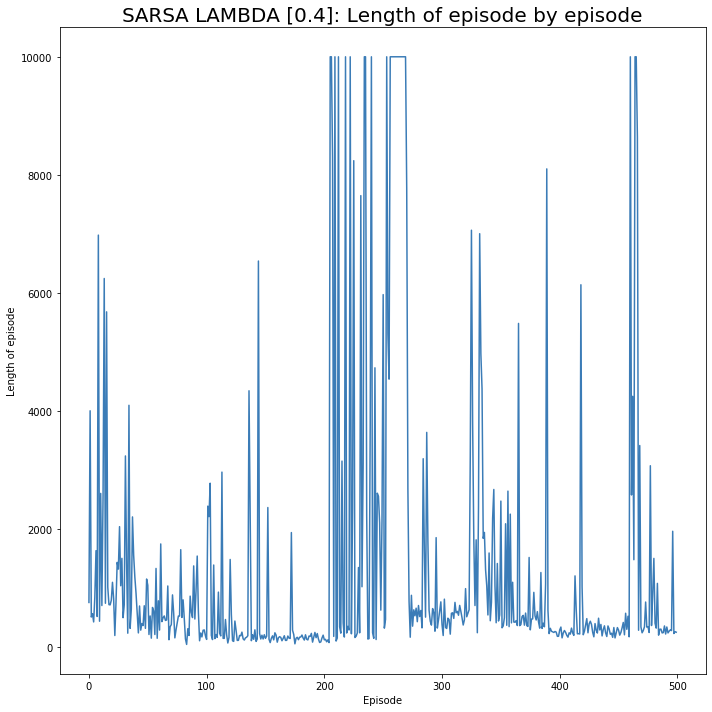

isode 357 finished after 431 time steps with total reward = 0.5689999999999997 (streak 0).
Episode 358 finished after 564 time steps with total reward = 0.4359999999999996 (streak 0).
Episode 359 finished after 579 time steps with total reward = 0.4209999999999996 (streak 0).
Episode 360 finished after 1209 time steps with total reward = -0.20899999999997765 (streak 0).
Episode 361 finished after 392 time steps with total reward = 0.6079999999999997 (streak 0).
Episode 362 finished after 1043 time steps with total reward = -0.04299999999999593 (streak 0).
Episode 363 finished after 548 time steps with total reward = 0.4519999999999996 (streak 0).
Episode 364 timed out at 9999 with total reward = -9.999999999999897.
Episode 365 timed out at 9999 with total reward = -9.999999999999897.
Episode 366 finished after 5192 time steps with total reward = -4.192000000000069 (streak 0).
Episode 367 timed out at 9999 with total reward = -9.999999999999897.
Episode 368 timed out at 9999 with total 

<Figure size 432x288 with 0 Axes>

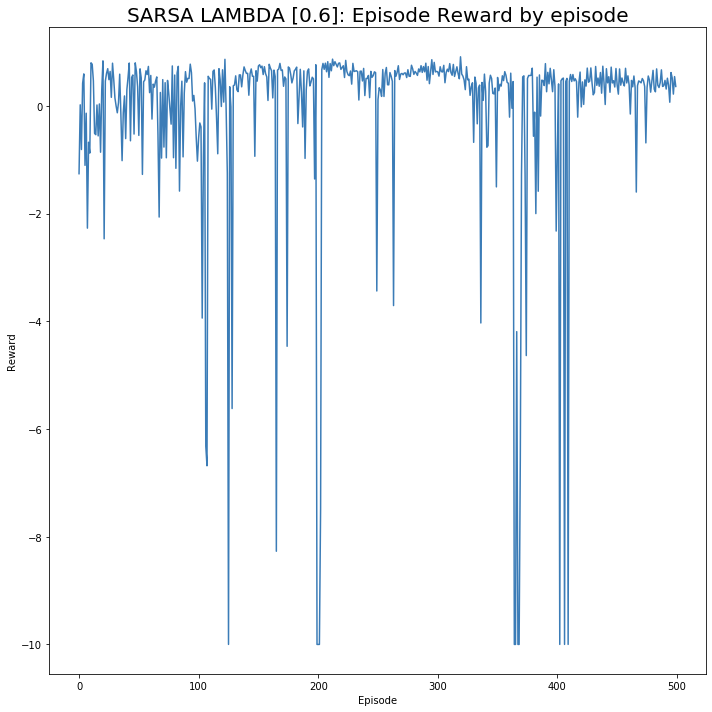

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

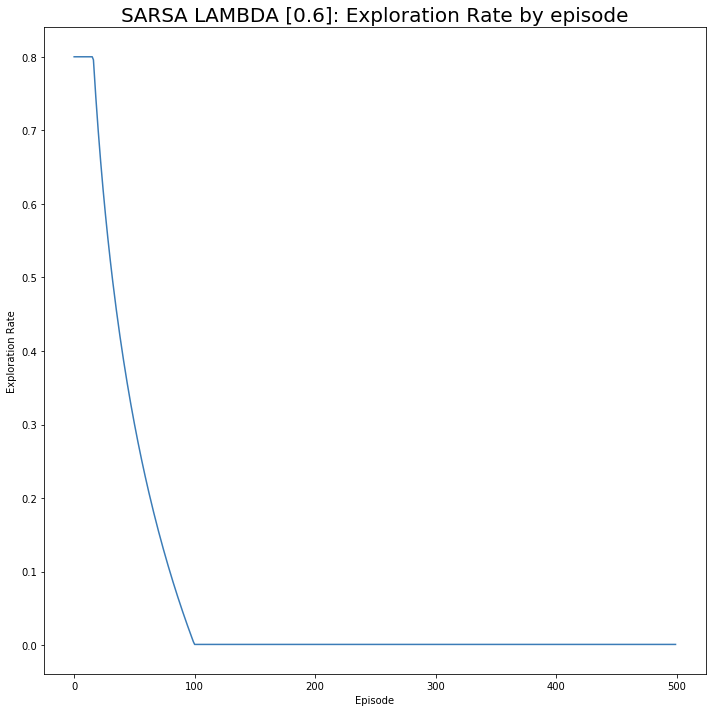

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

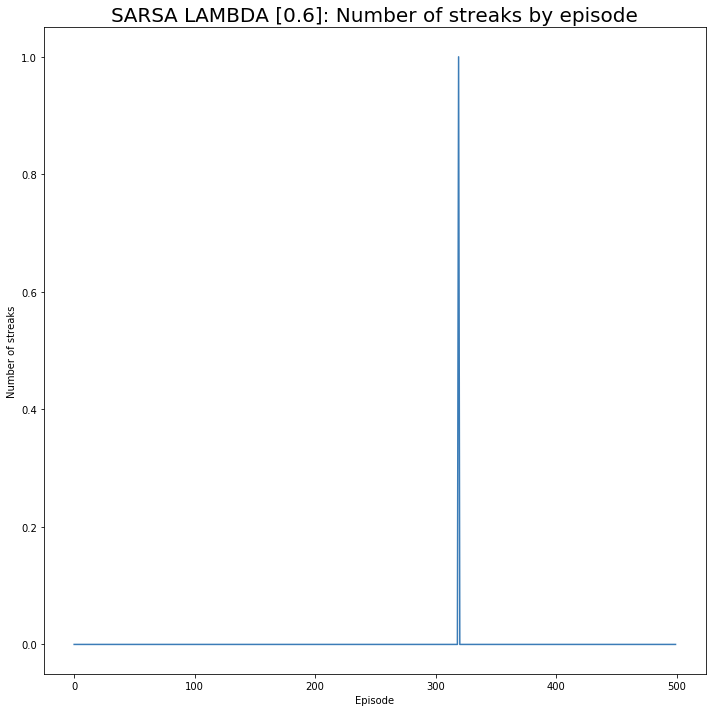

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

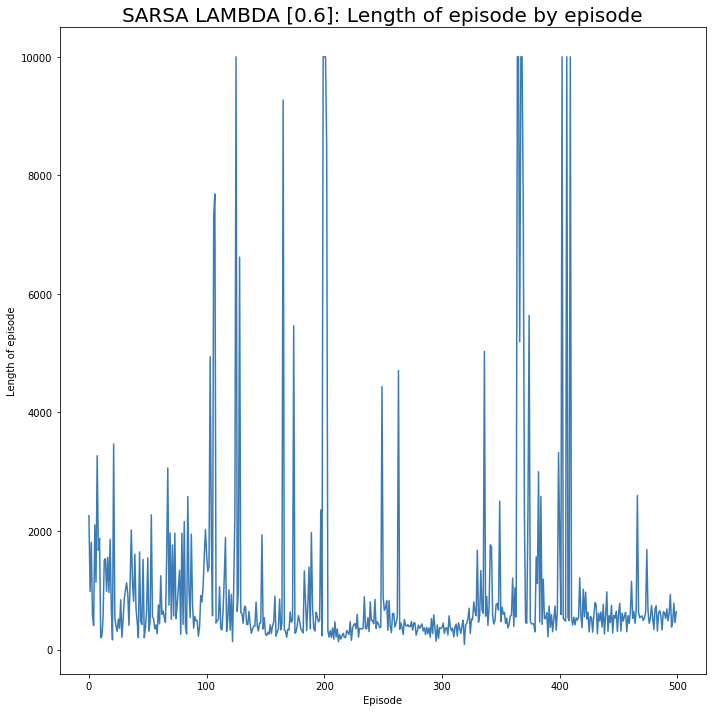

= -2.3109999999997464 (streak 0).
Episode 355 finished after 622 time steps with total reward = 0.37799999999999956 (streak 0).
Episode 356 finished after 3945 time steps with total reward = -2.9449999999996765 (streak 0).
Episode 357 finished after 685 time steps with total reward = 0.3149999999999995 (streak 0).
Episode 358 finished after 699 time steps with total reward = 0.3009999999999995 (streak 0).
Episode 359 finished after 855 time steps with total reward = 0.14499999999999935 (streak 0).
Episode 360 finished after 621 time steps with total reward = 0.37899999999999956 (streak 0).
Episode 361 finished after 784 time steps with total reward = 0.21599999999999941 (streak 0).
Episode 362 finished after 805 time steps with total reward = 0.1949999999999994 (streak 0).
Episode 363 finished after 1066 time steps with total reward = -0.0659999999999934 (streak 0).
Episode 364 finished after 702 time steps with total reward = 0.2979999999999995 (streak 0).
Episode 365 finished after 7

<Figure size 432x288 with 0 Axes>

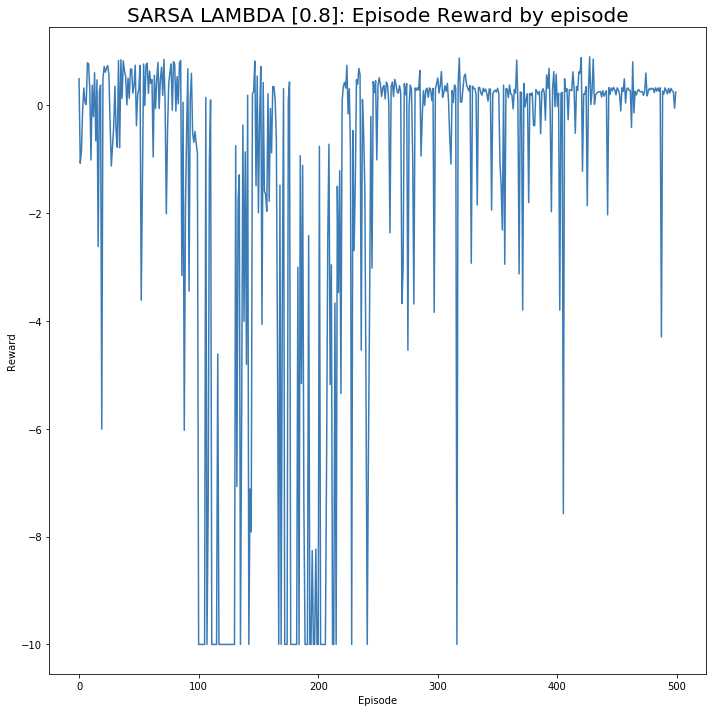

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

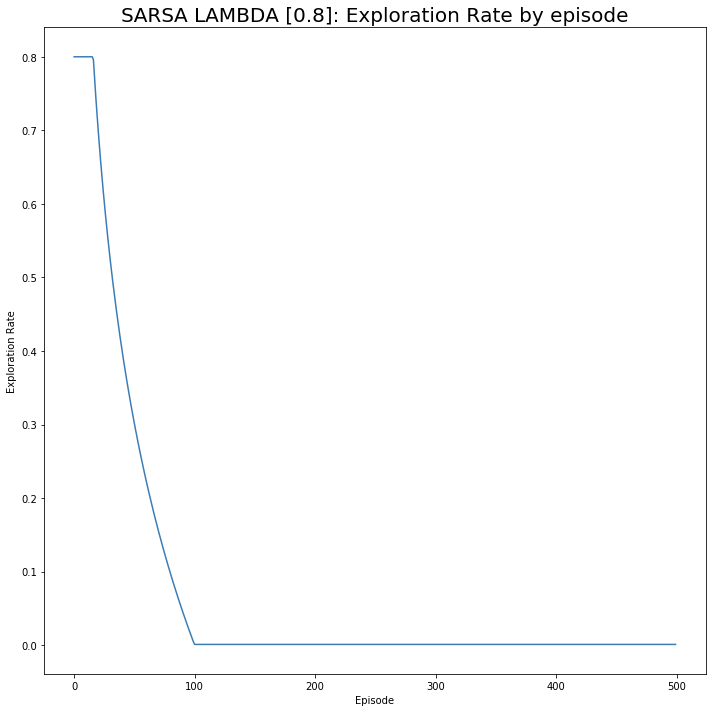

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

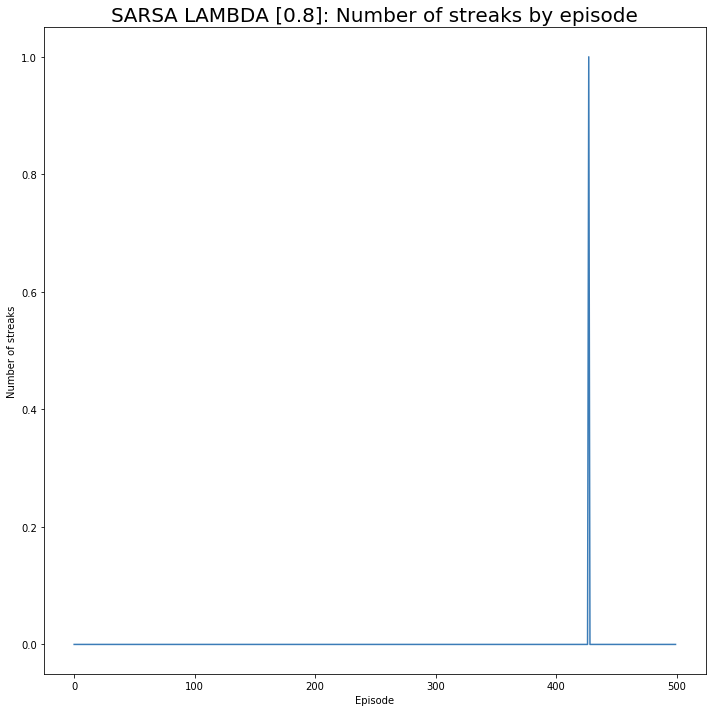

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

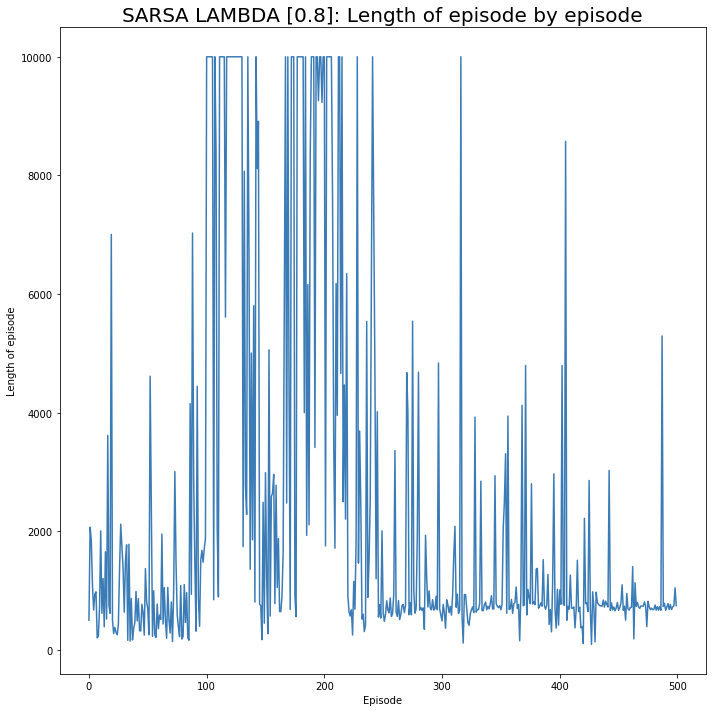

 total reward = 0.96 (streak 0).
Episode 289 timed out at 9999 with total reward = -9.999999999999897.
Episode 290 finished after 40 time steps with total reward = 0.96 (streak 1).
Episode 291 timed out at 9999 with total reward = -9.999999999999897.
Episode 292 finished after 1237 time steps with total reward = -0.23699999999997456 (streak 2).
Episode 293 finished after 41 time steps with total reward = 0.959 (streak 0).
Episode 294 finished after 41 time steps with total reward = 0.959 (streak 1).
Episode 295 timed out at 9999 with total reward = -9.999999999999897.
Episode 296 timed out at 9999 with total reward = -9.999999999999897.
Episode 297 finished after 41 time steps with total reward = 0.959 (streak 2).
Episode 298 timed out at 9999 with total reward = -9.999999999999897.
Episode 299 timed out at 9999 with total reward = -9.999999999999897.
Episode 300 timed out at 9999 with total reward = -9.999999999999897.
Episode 301 timed out at 9999 with total reward = -9.9999999999998

<Figure size 432x288 with 0 Axes>

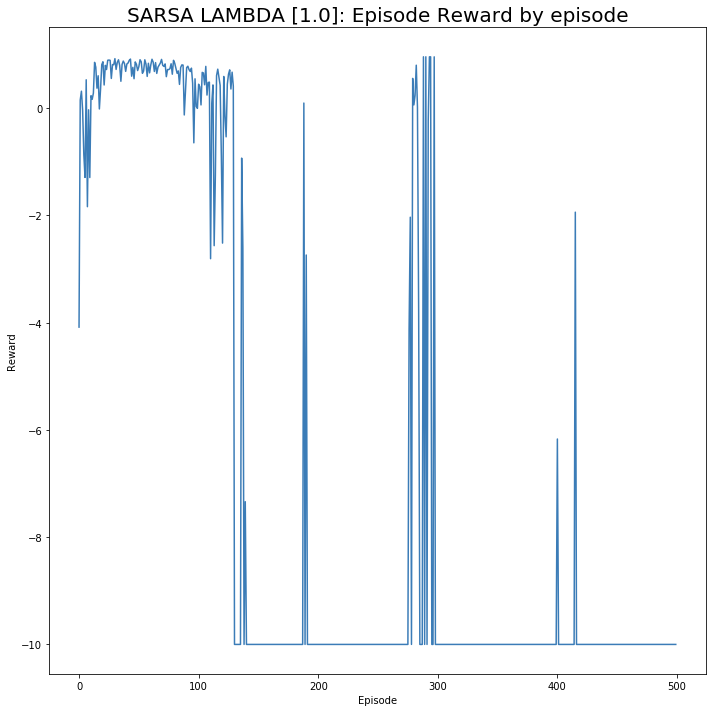

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

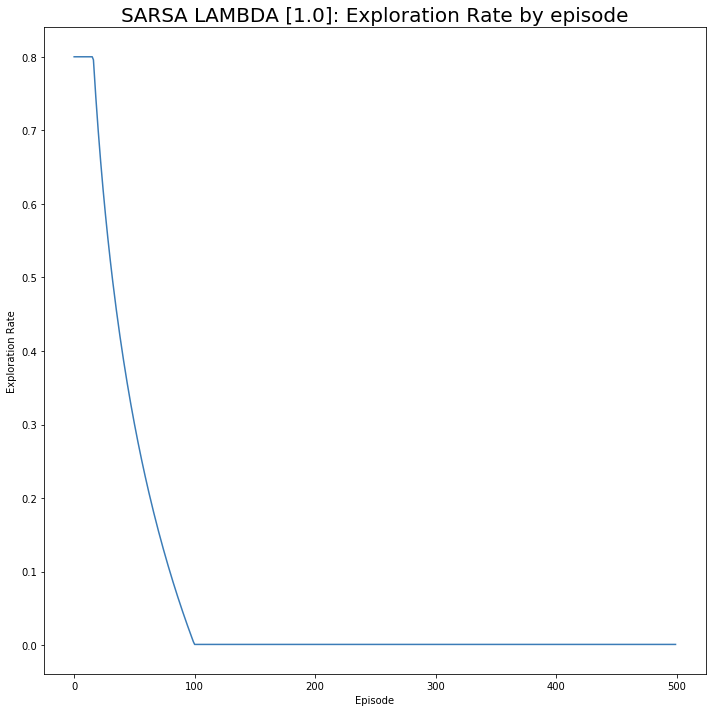

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

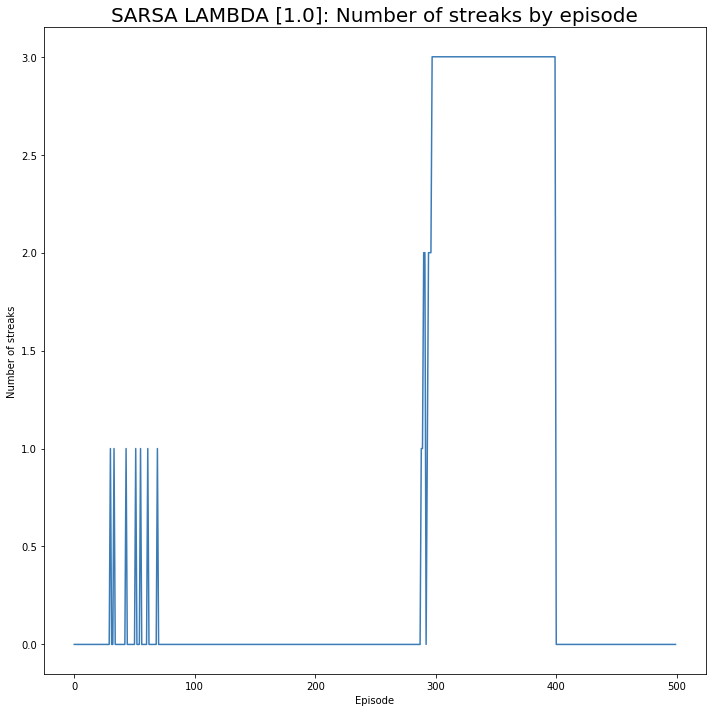

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

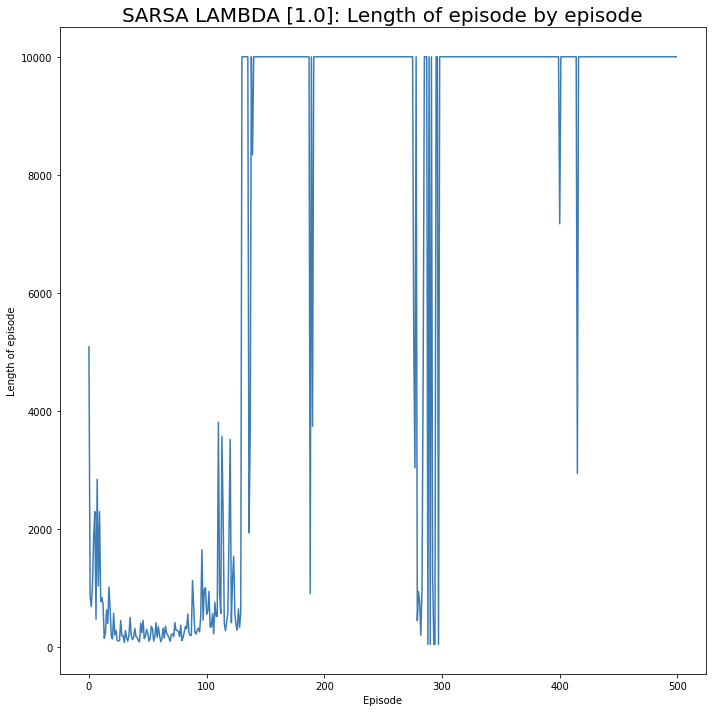

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\length_episode.png'


<Figure size 432x288 with 0 Axes>

In [8]:

reward_episode_array_list = []
explore_rate_episode_array_list = []
num_streaks_episode_array_list = []
length_episode_array_list = []

for i in range(len(LAMBDA_VAL_TRACE_DECAY_LIST)):
        SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY = os.path.join(SAVING_RESULTS_IMAGE_FODLER,str(LAMBDA_VAL_TRACE_DECAY_LIST[i]))

        
        LAMBDA_VAL_TRACE_DECAY = LAMBDA_VAL_TRACE_DECAY_LIST[i]
        print(f"================ Evaluating for LAMBDA = {LAMBDA_VAL_TRACE_DECAY}\n")

        reward_episode_array,explore_rate_episode_array,num_streaks_episode_array,length_episode_array = \
        simulate(discount_factor=DISCOUNT_FACTOR,
                learning_rate=LEARNING_RATE,
                epsilon=EPSILON,
                epsilon_decay=EPSILON_DECAY,
                trace_decay=LAMBDA_VAL_TRACE_DECAY)

        
        reward_episode_array_list.append(reward_episode_array)
        explore_rate_episode_array_list.append(explore_rate_episode_array)
        num_streaks_episode_array_list.append(num_streaks_episode_array)
        length_episode_array_list.append(length_episode_array)


        
        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"reward_episode")
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = ["None_Marker"],
                            title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Episode Reward by episode" ,
                                graph_saving_path = graph_saving_path)


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"explore_rate_episode")
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [explore_rate_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Exploration Rate",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Exploration Rate by episode" ,
                                graph_saving_path = graph_saving_path)


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"num_streaks_episode")
        plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [num_streaks_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Number of streaks",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Number of streaks by episode" ,
                                graph_saving_path = graph_saving_path)


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"length_episode")
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [length_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Length of episode",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Length of episode by episode" ,
                                graph_saving_path = graph_saving_path)


                                                                                                        
if ENABLE_RECORDING:
        env.close()

## Saving numpy arrays from results

In [9]:
for i in range(len(LAMBDA_VAL_TRACE_DECAY_LIST)):
    LAMBDA_VAL_FOLDER = os.path.join(SAVING_RESULTS_ARRAY_FODLER,str(LAMBDA_VAL_TRACE_DECAY_LIST[i]))
    create_folder_structure(LAMBDA_VAL_FOLDER)
    save_nparray_to_folder(reward_episode_array_list[i],LAMBDA_VAL_FOLDER,"reward_episode")
    save_nparray_to_folder(explore_rate_episode_array_list[i],LAMBDA_VAL_FOLDER,"explore_rate")
    save_nparray_to_folder(num_streaks_episode_array_list[i],LAMBDA_VAL_FOLDER,"num_streaks")
    save_nparray_to_folder(length_episode_array_list[i],LAMBDA_VAL_FOLDER,"length_episode")

reward_episode Shape:  (500,)
explore_rate Shape:  (500,)
num_streaks Shape:  (500,)
length_episode Shape:  (500,)
reward_episode Shape:  (500,)
explore_rate Shape:  (500,)
num_streaks Shape:  (500,)
length_episode Shape:  (500,)
reward_episode Shape:  (500,)
explore_rate Shape:  (500,)
num_streaks Shape:  (500,)
length_episode Shape:  (500,)
reward_episode Shape:  (500,)
explore_rate Shape:  (500,)
num_streaks Shape:  (500,)
length_episode Shape:  (500,)
reward_episode Shape:  (500,)
explore_rate Shape:  (500,)
num_streaks Shape:  (500,)
length_episode Shape:  (500,)
reward_episode Shape:  (500,)
explore_rate Shape:  (500,)
num_streaks Shape:  (500,)
length_episode Shape:  (500,)


In [10]:
# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [reward_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Reward",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Episode Reward by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode_array")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [explore_rate_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Exploration Rate",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Exploration Rate by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"learning_rate_episode_array")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [learning_rate_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Learning Rate",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Learning Rate by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode_array")
# plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [num_streaks_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Number of streaks",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Number of streaks by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode_array")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [length_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Length of episode",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Length of episode by episode" ,
#                             graph_saving_path = graph_saving_path)

In [11]:
# reward_episode_array_list = []
# explore_rate_episode_array_list = []
# learning_rate_episode_array_list = []
# num_streaks_episode_array_list = []
# length_episode_array_list = []
# for LAMBDA_VAL_TRACE_DECAY in LAMBDA_VAL_TRACE_DECAY_LIST:

#         print(f"================ Evaluating for LAMBDA = {LAMBDA_VAL_TRACE_DECAY}\n")

#         reward_episode_array,explore_rate_episode_array,learning_rate_episode_array,num_streaks_episode_array,length_episode_array = \
#         simulate(discount_factor=DISCOUNT_FACTOR,
#                 eligibility_decay=ELIGIBILITY_DECAY,
#                 epsilon=EPSILON,
#                 epsilon_decay=EPSILON_DECAY,
#                 trace_decay=LAMBDA_VAL_TRACE_DECAY)


#         reward_episode_array_list.append(reward_episode_array)
#         explore_rate_episode_array_list.append(explore_rate_episode_array)
#         learning_rate_episode_array_list.append(learning_rate_episode_array)
#         num_streaks_episode_array_list.append(num_streaks_episode_array)
#         length_episode_array_list.append(length_episode_array)

                                                                                                        
# if ENABLE_RECORDING:
#         env.close()

In [12]:
# x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)] for num_streaks_episode_array in num_streaks_episode_array_list]
# legends = [f"Lambda {LAMBDA_VAL_TRACE_DECAY}" for LAMBDA_VAL_TRACE_DECAY in LAMBDA_VAL_TRACE_DECAY_LIST]


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = reward_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Reward",
#                         legends = legends,
#                         title = "Sarsa Lambda: Episode Reward by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode_array")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = explore_rate_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Exploration Rate",
#                         legends = legends,
#                         title = "Sarsa Lambda: Exploration Rate by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"learning_rate_episode_array")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = learning_rate_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Learning Rate",
#                         legends = legends,
#                         title = "Sarsa Lambda: Learning Rate by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode_array")
# plot_line_graphs_overlayed(x_list =x_list,
#                         y_list = num_streaks_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Number of streaks",
#                         legends = legends,
#                         title = "Sarsa Lambda: Number of streaks by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode_array")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = length_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Length of episode",
#                         legends = legends,
#                         title = "Sarsa Lambda: Length of episode by episode" ,
#                         graph_saving_path = graph_saving_path)